## [Dacon]태양광 발전량 예측 AI 경진대회
## 우럭이 안우럭
## 2021년 1월 31일 

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline
import math
import itertools
import warnings
warnings.filterwarnings(action='ignore')
from tqdm import tnrange, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('../data/train/train.csv')
submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [3]:
df.isnull().sum()

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

In [4]:
df.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


## 3. 탐색적 자료분석
## Exploratory Data Analysis


In [5]:
# series = pd.Series(df['TARGET'])
# results = seasonal_decompose(series, model='additive',freq = 365)
# plt.rcParams['figure.figsize'] = (20.0, 10.0)
# results.plot()
# plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [6]:
# 최적의 전천일사량을 위한 각도 search
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    df['GHI'] = df['DNI']*math.cos(math.pi/180*i)+df['DHI']
    makeCorrList(df)

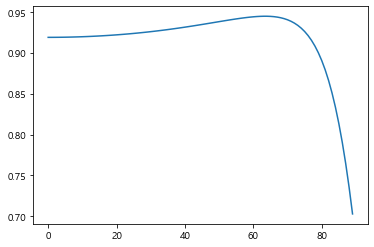

In [7]:
x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

In [8]:
print(corrList.index(max(corrList)), max(corrList))

63 0.9451229383187152


In [39]:
# 이슬점온도 Column 추가
def makeDewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [40]:
# 전천일사량 컬럼 추가
df['GHI'] = df['DNI']*math.cos(math.pi/180*63)+df['DHI']
df['DP'] = 0
for i in range(len(df)):
    df.loc[i, ["DP"]] = makeDewpoint(float(df.loc[i, ["T"]]), df.loc[i , ["RH"]])

In [43]:
df = df.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])

<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

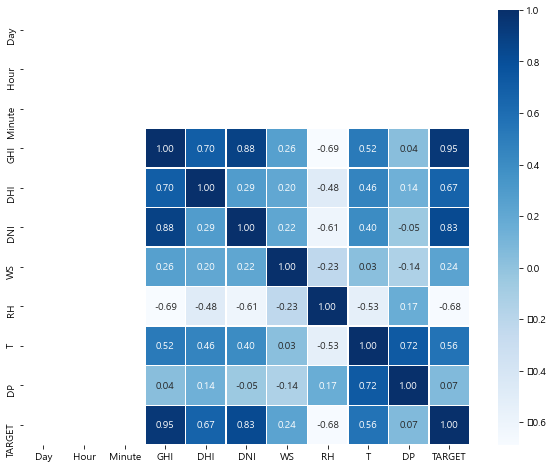

In [42]:
# feature간 상관계수
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), annot=True,
fmt='.2f', linewidths=.5, cmap='Blues')

In [44]:
df = df.drop(['Day', 'Hour', 'Minute'], axis = 1)
init_x_train = df.drop(['TARGET'], axis = 1)
init_y_train = df['TARGET']

In [46]:
# train test split
def preprocess(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels
x_col = ["GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"]
y_col = ["TARGET"]
dataset = df.loc[:,x_col].values
label = np.ravel(df.loc[:,y_col].values)

past_history = 48 * 7
future_target = 48 * 2

### train set
train_data, train_label = preprocess(dataset, label, 0, None, past_history,future_target, 1)
train_data = np.nan_to_num(train_data)

In [47]:
def random_forest(X,y):
    model = RandomForestRegressor(n_estimators=500, max_features=0.25)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

In [48]:
# randomforest feature optimization
m = len(init_y_train)
k = 7
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(init_x_train.columns) + 1):
    for combo in itertools.combinations(init_x_train.columns,k):
        tmp_result = random_forest(init_x_train[list(combo)],init_y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
eda = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

KeyboardInterrupt: 

In [18]:
# randomforest feature optimization
eda['min_RSS'] = eda.groupby('numb_features')['RSS'].transform(min)
eda['max_R_squared'] = eda.groupby('numb_features')['R_squared'].transform(max)
eda.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,9.665056e+06,0.722880,"(DHI,)",285875.962296,0.991803
1,1,7.623668e+06,0.781412,"(DNI,)",285875.962296,0.991803
2,1,3.247042e+07,0.068998,"(WS,)",285875.962296,0.991803
3,1,1.259526e+07,0.638865,"(RH,)",285875.962296,0.991803
4,1,2.144675e+07,0.385072,"(T,)",285875.962296,0.991803


In [19]:
eda_min = eda[eda.groupby('numb_features')['RSS'].transform(min) == eda['RSS']]
eda_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
5,1,285875.962296,0.991803,"(GHI,)",285875.962296,0.991803
16,2,114116.603860,0.996728,"(DNI, GHI)",114116.603860,0.996728
40,3,13869.044390,0.999602,"(DHI, T, GHI)",13869.044390,0.999602
70,4,13104.789327,0.999624,"(DHI, DNI, T, GHI)",13104.789327,0.999624
107,5,9107.825401,0.999739,"(DHI, DNI, T, GHI, DP)",9107.825401,0.999739
122,6,11636.301039,0.999666,"(DHI, DNI, WS, T, GHI, DP)",11636.301039,0.999666
126,7,16667.569401,0.999522,"(DHI, DNI, WS, RH, T, GHI, DP)",16667.569401,0.999522


In [15]:
# real model feature selection, data transformation
### train set
train_data, train_label = preprocess(dataset, label, 0, None, past_history,future_target, 1)
### test test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'./data/test/{i}.csv')
    tmp['GHI'] = tmp['DNI']*math.cos(math.pi/180*63)+tmp['DHI']
    tmp['DP'] = 0
    for i in range(len(tmp)):
        tmp.loc[i, ["DP"]] = makeDewpoint(float(tmp.loc[i, ["T"]]), tmp.loc[i , ["RH"]])    
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

train_data = np.nan_to_num(train_data)

In [ ]:
print(train_data.shape)
print(train_label.shape)

In [ ]:
# Hyperparameter optimization
features = []
x_features = np.arange(1,21)
N_ESTIMATORS = 500

for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    features.append(rf.score(train_data, train_label))

depth = []
x_depth = np.arange(1,21)
N_ESTIMATORS = 1000
for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=5, random_state=0,
                                    max_depth = i,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    depth.append(rf.score(train_data, train_label))
    
estimator = []
x_estimator = np.arange(1000,2100,100)
for i in range(1000,2100,100):
    rf = RandomForestRegressor(n_estimators=i,
                                    max_features=5, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    estimator.append(rf.score(train_data, train_label))

Text(0.5, 0, 'features')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'depth')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'estimator')

Text(0, 0.5, 'accuracy')

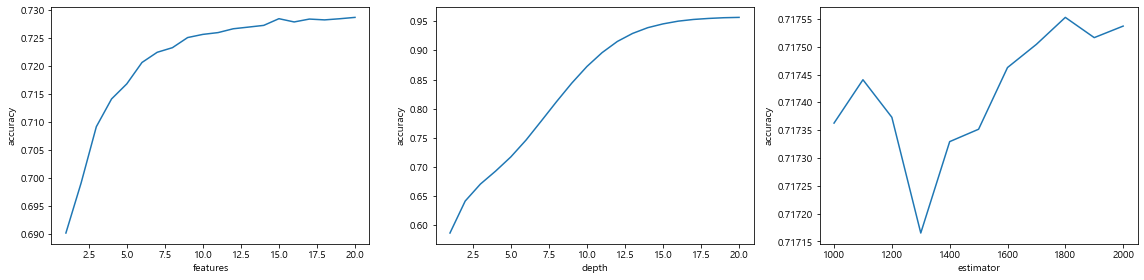

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

x = np.linspace(0, 1, 100)

axes[0].plot(x_features, features)
axes[0].set_xlabel("features")
axes[0].set_ylabel("accuracy")
axes[1].plot(x_depth, depth)
axes[1].set_xlabel("depth")
axes[1].set_ylabel("accuracy")
axes[2].plot(x_estimator, estimator)
axes[2].set_xlabel("estimator")
axes[2].set_ylabel("accuracy")

fig.tight_layout()

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [19]:
# random forest real modeling
from sklearn.ensemble import RandomForestRegressor
N_ESTIMATORS = 1800
features = 20
depth = 20

rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=features, random_state=0,
                                    max_depth = depth,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)
print("Clear")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   16.3s finished


RandomForestRegressor(max_depth=20, max_features=20, n_estimators=1800,
                      n_jobs=-1, random_state=0, verbose=True)

Clear


## 6. 결과 및 결언
## Conclusion & Discussion

In [20]:
# prediction
rf_preds = []
for estimator in rf.estimators_:
    result = estimator.predict(test).astype(np.float64)
    rf_preds.append(result)
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    
    submission.iloc[:, i] = np.ravel(y_pred)

In [21]:
submission.to_csv(f'finalfinal_1.csv')